# Setup

This Experiment is the main experiment of the work, consists in run an optimized Random Forest in order to try to predict the values in question.(https://www.researchgate.net/publication/221533996_From_an_artificial_neural_network_to_a_stock_market_day-trading_system_A_case_study_on_the_BMF_BOVESPA).

In [3]:
import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

### Constants and Parameters

In [4]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2018.03.30'
TRAIN_END = '2021.04.05'
TIMES = 10

### Opening the dataset

In [45]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df2 = pd.read_csv('../Data/VALE3_Daily.csv', sep = "\t")
df2.columns = dfColumns
df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

fundo = "JBSS3"
df3 = pd.read_csv(f'../Data/{fundo}_Daily.csv', sep = "\t")
df3.columns = dfColumns
df3 = removeColumns(df3, ['tickvol', 'volume','spread'])

df 
df.tail(290)

,date,open,high,low,close
1049,2020.03.31,13.16,14.07,13.16,13.54
1050,2020.04.01,13.01,14.08,12.89,13.84
1051,2020.04.02,14.90,16.01,14.52,15.01
1052,2020.04.03,15.77,15.83,14.44,14.84
1053,2020.04.06,15.53,15.58,14.69,15.26
...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09
1335,2021.05.27,26.08,26.25,25.77,25.91
1336,2021.05.28,26.20,27.02,26.15,26.99
1337,2021.05.31,26.96,27.20,26.78,26.87


In [46]:
#PETR4
df = calculateEMA(df,DAYS,newColumns)
df = calculateBB(df,DAYS,newColumns)
df = addPreviousDays(df,DAYS, newColumns)

#VALE3
df2 = calculateEMA(df2,DAYS,newColumns)
df2 = calculateBB(df2,DAYS,newColumns)
df2 = addPreviousDays(df2,DAYS, newColumns)

#
df3 = calculateEMA(df3,DAYS,newColumns)
df3 = calculateBB(df3,DAYS,newColumns)
df3 = addPreviousDays(df3,DAYS, newColumns)

In [47]:
initialDf_PETR4 = getPeriod(df, '2016.01.04','2021.06.01', True)
initialDf_VALE3 = getPeriod(df2, '2016.01.04','2021.06.01', True)
initialDf_ = getPeriod(df3, '2017.06.01','2021.06.01', True)

In [7]:
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2016.01.04,5.96,6.38,5.94,6.23,5.960000,6.380000,5.940000,6.230000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016.01.05,6.28,6.35,6.00,6.06,6.280000,6.350000,6.000000,6.060000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016.01.06,5.92,5.93,5.80,5.80,5.920000,5.930000,5.800000,5.800000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016.01.07,5.61,5.83,5.51,5.68,5.610000,5.830000,5.510000,5.680000,NaN,...,5.94,6.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016.01.08,5.79,5.85,5.56,5.69,6.053333,6.220000,5.913333,6.030000,6.405842,...,6.00,6.06,5.96,6.38,5.94,6.23,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.608719,...,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
1335,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.604087,...,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
1336,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,26.617551,...,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
1337,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.147657,...,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


In [8]:
initialDf_VALE3

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2016.01.04,10.57,10.99,10.56,10.74,10.570000,10.990000,10.560000,10.740000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016.01.05,10.73,10.87,10.50,10.60,10.730000,10.870000,10.500000,10.600000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016.01.06,10.23,10.25,9.81,9.82,10.230000,10.250000,9.810000,9.820000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016.01.07,9.53,9.62,9.21,9.24,9.530000,9.620000,9.210000,9.240000,NaN,...,10.56,10.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016.01.08,9.37,9.52,8.92,8.92,10.510000,10.703333,10.290000,10.386667,11.307278,...,10.50,10.60,10.57,10.99,10.56,10.74,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,2021.05.26,106.37,110.32,106.03,110.20,109.166674,111.131617,107.622606,109.807900,113.973861,...,108.50,109.40,111.70,112.10,110.20,111.11,112.10,112.78,109.84,112.25
1335,2021.05.27,110.80,112.09,109.77,110.99,109.711116,111.451078,108.338404,110.201933,113.405981,...,107.51,109.78,111.11,111.25,108.50,109.40,111.70,112.10,110.20,111.11
1336,2021.05.28,111.11,112.75,109.42,111.59,110.177411,111.884052,108.698936,110.664622,113.405981,...,106.78,107.05,108.00,110.14,107.51,109.78,111.11,111.25,108.50,109.40
1337,2021.05.31,112.50,114.89,112.50,114.78,110.951607,112.886035,109.965957,112.036415,114.811204,...,106.03,110.20,110.28,110.89,106.78,107.05,108.00,110.14,107.51,109.78


In [140]:
initialDf_

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.06.01,6.99,7.43,6.69,6.74,6.990000,7.430000,6.690000,6.740000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017.06.02,6.88,7.01,6.39,6.53,6.880000,7.010000,6.390000,6.530000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017.06.05,6.51,6.58,6.24,6.27,6.510000,6.580000,6.240000,6.270000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017.06.06,6.50,6.90,6.36,6.79,6.500000,6.900000,6.360000,6.790000,NaN,...,6.69,6.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017.06.07,6.79,7.01,6.57,6.62,6.793333,7.006667,6.440000,6.513333,7.175497,...,6.39,6.53,6.99,7.43,6.69,6.74,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2021.05.26,28.04,28.48,27.84,27.87,27.847056,28.196765,27.528520,27.763789,28.184951,...,27.48,27.59,27.49,27.91,27.17,27.73,27.05,27.64,26.60,27.41
984,2021.05.27,27.98,28.17,27.55,27.60,27.891370,28.187843,27.535680,27.709193,28.175641,...,27.18,27.55,27.88,28.21,27.48,27.59,27.49,27.91,27.17,27.73
985,2021.05.28,27.71,27.81,27.29,27.62,27.830914,28.061896,27.453787,27.679462,28.168821,...,27.57,27.86,27.66,27.86,27.18,27.55,27.88,28.21,27.48,27.59
986,2021.05.31,27.74,27.85,27.53,27.74,27.800609,27.991264,27.479191,27.699641,28.150500,...,27.84,27.87,27.76,28.08,27.57,27.86,27.66,27.86,27.18,27.55


### Experimento Adrion:

In [8]:
def exp(df, inputColumns = []):
    #df = getPeriod(df, '2020.03.02','2021.04.30', True)
    #print(df)
    
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    rf = RandomForestRegressor(n_estimators = 500)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    
    errorMax = mape(y_test['high'],y_pred[:,0])
    errorMin = mape(y_test['low'],y_pred[:,1])
    
    return errorMax, errorMin

def test30timesExp(df, phrase, columnInput = []):
    errorMax = []
    errorMin = []
    
    for i in range(1, TIMES+1):
        if(columnInput == []):
            errorMax_petr4, errorMin_petr4 = exp(df)
        else: 
            errorMax_petr4, errorMin_petr4 = exp(df, columnInput)
            
        errorMax.append(errorMax_petr4[0])
        errorMin.append(errorMin_petr4[0])
    
    errorMax = np.array(errorMax)
    errorMin = np.array(errorMin)
    print(phrase)
    printResult((errorMax.mean(),errorMax.std()), 'High')
    printResult((errorMin.mean(),errorMin.std()), 'Low')
    
test30timesExp(initialDf_PETR4, 'PETR4 15 Variables', col15) 
test30timesExp(initialDf_PETR4, 'PETR4 25 Variables', col25) 
test30timesExp(initialDf_PETR4, 'PETR4 33 Variables') 
print('\n')
test30timesExp(initialDf_VALE3, 'VALE3 15 Variables', col15) 
test30timesExp(initialDf_VALE3, 'VALE3 25 Variables', col25) 
test30timesExp(initialDf_VALE3, 'VALE3 33 Variables')     

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
df4 = getPeriod(initialDf_PETR4, '2020.03.02','2021.04.30', True)

df_train = getPeriod(df4, '2020.03.02','2021.03.31')
df_test = getPeriod(df4, '2021.04.01','2021.04.30')

x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
y_train = df_train[['high','low']]

x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
y_test = df_test[['high','low']]

rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print (mape(y_test['high'],y_pred[:,0]))
print (mape(y_test['low'],y_pred[:,1]))
print (mae(y_test['high'],y_pred[:,0]))
print (mae(y_test['low'],y_pred[:,1]))

(1.2097407745304578, 1.1680444381642863)
(0.816605545046884, 0.6794028981892051)
(0.29008449999985864, 0.2887711786948039)
(0.1901740000000734, 0.15932806398754892)


Feature: open, Score: 0.88575
Feature: EMA_open, Score: 0.00110
Feature: EMA_high, Score: 0.00360
Feature: EMA_low, Score: 0.00891
Feature: EMA_close, Score: 0.01701
Feature: UB_open, Score: 0.00031
Feature: LB_open, Score: 0.00919
Feature: UB_high, Score: 0.00064
Feature: LB_high, Score: 0.00677
Feature: UB_low, Score: 0.00122
Feature: LB_low, Score: 0.00278
Feature: UB_close, Score: 0.00115
Feature: LB_close, Score: 0.01141
Feature: d-1_open, Score: 0.00179
Feature: d-1_high, Score: 0.00763
Feature: d-1_low, Score: 0.01096
Feature: d-1_close, Score: 0.02327
Feature: d-2_open, Score: 0.00018
Feature: d-2_high, Score: 0.00029
Feature: d-2_low, Score: 0.00209
Feature: d-2_close, Score: 0.00153
Feature: d-3_open, Score: 0.00012
Feature: d-3_high, Score: 0.00013
Feature: d-3_low, Score: 0.00037
Feature: d-3_close, Score: 0.00041
Feature: d-4_open, Score: 0.00014
Feature: d-4_high, Score: 0.00016
Feature: d-4_low, Score: 0.00013
Feature: d-4_close, Score: 0.00018
Feature: d-5_open, Score: 

<BarContainer object of 33 artists>

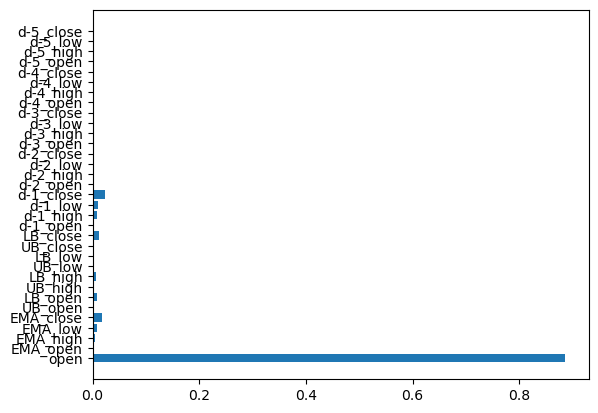

In [ ]:
importance = rf.feature_importances_
feature_names = x_train.columns  
for name, score in zip(feature_names, importance):
    print(f'Feature: {name}, Score: {score:.5f}')

importance

from matplotlib import pyplot as plt
plt.barh(x_train.columns, rf.feature_importances_)

In [ ]:
def exp041(df, inputColumns = []):
    #df = getPeriod(df, '2020.03.02','2021.04.30', True)
    
    #print(df)
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    for i in range(1, 5):    
        rf = RandomForestRegressor(n_estimators = 300)
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        
        print(i)
        errorMax = mape(y_test['high'],y_pred[:,0])
        errorMin = mape(y_test['low'],y_pred[:,1])
        printResult(errorMax, 'High')
        printResult(errorMin, 'Low')
    
    importance = rf.feature_importances_
    
    featureImp = []
    for feat, importance in zip(x_train.columns, rf.feature_importances_):  
        temp = [feat, importance*100]
        featureImp.append(temp)

    #fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
    #print (fT_df.sort_values('Importance', ascending = False))
    
    #print (mape(y_test['high'],y_pred[:,0]))
    #print (mape(y_test['low'],y_pred[:,1]))
    #print (mae(y_test['high'],y_pred[:,0]))
    #print (mae(y_test['low'],y_pred[:,1]))
    
    return errorMax, errorMin, y_pred, y_test

a,b,c,d = exp041(initialDf_PETR4)

e,f,g,h = exp041(initialDf_VALE3)

1
High: 1.05 +- 0.94 %
Low: 0.68 +- 0.44 %
2
High: 1.1 +- 0.93 %
Low: 0.69 +- 0.44 %
3
High: 1.05 +- 0.94 %
Low: 0.65 +- 0.44 %
4
High: 1.08 +- 0.93 %
Low: 0.69 +- 0.46 %
1
High: 7.95 +- 3.38 %
Low: 8.63 +- 2.99 %
2
High: 7.83 +- 3.37 %
Low: 8.55 +- 2.98 %
3
High: 8.05 +- 3.37 %
Low: 8.68 +- 2.98 %
4
High: 7.88 +- 3.39 %
Low: 8.58 +- 2.99 %


In [ ]:
for df in [initialDf_ABEV3]:
    for normalization in ["minmax", "standard", "power", None]:
        a,b,c,d,e = exp041(df, normalizer=normalization)
        result_prediction = pd.DataFrame()
        result_prediction['date'] = getPeriod(df, TEST_BEGIN, TEST_END)['date']
        result_prediction['high_pred'] = c[:,0]
        result_prediction['low_pred'] = c[:,1]
        result_prediction['uncertainty_high'] = e[:,0]
        result_prediction['uncertainty_low'] = e[:,1]
        result_prediction['uncertainty_mean'] = (result_prediction['uncertainty_high'] + result_prediction['uncertainty_low']) / 2
        result_prediction['high'] = d['high']
        result_prediction['low'] = d['low']
        result_prediction.to_pickle('../Data/PETR4_Pred_with_confidence.pkl')
        result_prediction.tail(10)

In [ ]:
printResult(a, 'High')
printResult(b, 'Low')

High: 1.08 +- 0.93 %
Low: 0.69 +- 0.46 %


In [ ]:
d['high_pred'] = c[:,0]
d['low_pred'] = c[:,1]
d['date'] = getPeriod(initialDf_PETR4, TEST_BEGIN, TEST_END)['date']
d.to_pickle('../Data/PETR4_Pred.pkl')
d.tail(10)


,high,low,high_pred,low_pred,date
589,26.35,25.80,26.535933,25.722600,2021.05.19
590,26.28,25.72,26.385000,25.679233,2021.05.20
591,26.31,25.94,26.491167,25.709767,2021.05.21
592,26.52,25.99,26.617400,25.806100,2021.05.24
593,26.62,25.78,26.718667,25.938800,2021.05.25
594,26.18,25.65,26.325033,25.600600,2021.05.26
595,26.25,25.77,26.362300,25.643967,2021.05.27
596,27.02,26.15,26.872600,26.006533,2021.05.28
597,27.20,26.78,27.203500,26.543933,2021.05.31
598,27.70,27.01,27.576467,27.126167,2021.06.01


In [ ]:
h['high_pred'] = g[:,0]
h['low_pred'] = g[:,1]
h['date'] = getPeriod(initialDf_VALE3, TEST_BEGIN, TEST_END)['date']
h.to_pickle('../Data/VALE3_Pred.pkl')
h.tail(10)

,high,low,high_pred,low_pred,date
589,112.78,109.84,102.342633,99.039733,2021.05.19
590,112.10,110.20,102.342633,99.039733,2021.05.20
591,111.25,108.50,102.342633,99.039733,2021.05.21
592,110.14,107.51,102.342633,99.039733,2021.05.24
593,110.89,106.78,102.342633,99.039733,2021.05.25
594,110.32,106.03,102.342633,99.039733,2021.05.26
595,112.09,109.77,102.342633,99.039733,2021.05.27
596,112.75,109.42,102.342633,99.039733,2021.05.28
597,114.89,112.50,102.342633,99.039733,2021.05.31
598,118.00,113.20,102.342633,99.039733,2021.06.01


In [ ]:
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2019.01.02,21.18,22.73,20.93,22.60,20.609175,21.499077,20.380957,21.271656,21.776315,...,19.18,20.37,19.55,20.08,19.41,19.69,20.38,20.39,19.50,19.63
1,2019.01.03,22.51,23.32,22.36,23.16,21.242783,22.106051,21.040638,21.901104,23.157151,...,19.99,20.36,19.34,20.37,19.18,20.37,19.55,20.08,19.41,19.69
2,2019.01.04,23.35,23.43,22.99,23.22,21.945189,22.547367,21.690425,22.340736,24.186721,...,20.74,21.31,20.22,20.65,19.99,20.36,19.34,20.37,19.18,20.37
3,2019.01.07,23.35,24.35,23.20,23.59,22.413459,23.148245,22.193617,22.757157,24.644733,...,20.93,22.60,20.77,21.45,20.74,21.31,20.22,20.65,19.99,20.36
4,2019.01.08,23.86,23.88,23.27,23.45,22.895640,23.392163,22.552411,22.988105,24.953473,...,22.36,23.16,21.18,22.73,20.93,22.60,20.77,21.45,20.74,21.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.608719,...,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
595,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.604087,...,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
596,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,26.617551,...,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
597,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.147657,...,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


# Testes Joao

In [14]:
import pdb

In [15]:
df_importance = []
def exp041(df, normalizer = "", inputColumns = [], TRAIN_BEGIN = '2018.04.02', TRAIN_END = '2021.02.03', VALID_BEGIN = '2021.02.04', VALID_END = '2021.04.05', TEST_BEGIN = '2021.04.06', TEST_END = '2021.06.01'):
    
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_valid = getPeriod(df, VALID_BEGIN, VALID_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_valid = df_valid.drop(['date', 'high', 'low', 'close'], axis=1)
        y_valid = df_valid[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_valid = df_valid[inputColumns]
        y_valid = df_valid[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    if(normalizer == "minmax"):
        scaler = MinMaxScaler()
        scaler_alvo = MinMaxScaler()
    elif(normalizer == "standard"):
        scaler = StandardScaler()
        scaler_alvo = StandardScaler()
    elif(normalizer == "power"):
        scaler = PowerTransformer()
        scaler_alvo = PowerTransformer()

    if(normalizer != ""):
        # Selecionar apenas colunas numéricas para normalizar
        numeric_cols = x_train.select_dtypes(include=['number']).columns
        
        scaler.fit(pd.concat([x_train[numeric_cols], x_valid[numeric_cols]]))

        # Aplicar normalização apenas nas colunas numéricas
        x_train[numeric_cols] = scaler.transform(x_train[numeric_cols])
        x_valid[numeric_cols] = scaler.transform(x_valid[numeric_cols])
        x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

        y_train = pd.DataFrame(scaler_alvo.fit_transform(y_train),columns=y_train.columns,index=y_train.index)
        y_valid = pd.DataFrame(scaler_alvo.transform(y_valid),columns=y_valid.columns,index=y_valid.index)
        y_test = pd.DataFrame(scaler_alvo.transform(y_test),columns=y_test.columns,index=y_test.index)

    best_y_pred = None
    best_uncertainty_valid = None
    best_uncertainty_test = None
    best_errorMax = (float('inf'), float('inf'))
    best_errorMin = (float('inf'), float('inf'))    

    for i in range(1, 5):    
        rf = RandomForestRegressor(n_estimators = 300)
        rf.fit(x_train, y_train)
        # Obter previsões individuais de cada árvore
        predictions_per_tree = np.array([tree.predict(x_test) for tree in rf.estimators_])
        predictions_per_tree_valid = np.array([tree.predict(x_valid) for tree in rf.estimators_])
        # Média das predições (previsão final)
        y_pred = predictions_per_tree.mean(axis=0)
        # Desvio padrão como medida de incerteza/confiança
        
        uncertainty_valid = predictions_per_tree_valid.std(axis=0)
        uncertainty_test = predictions_per_tree.std(axis=0)
        pdb.set_trace()
        errorMax = mape(y_test['high'],y_pred[:,0])
        errorMin = mape(y_test['low'],y_pred[:,1])
        printResult(errorMax, 'High')
        printResult(errorMin, 'Low')

        if errorMax[1] < best_errorMax[1] and errorMin[1] < best_errorMin[1]:
            best_y_pred = y_pred
            best_uncertainty_valid = uncertainty_valid
            best_uncertainty_test = uncertainty_test
            best_errorMax = errorMax
            best_errorMin = errorMin
    
    if(normalizer != ""):
        y_pred = scaler_alvo.inverse_transform(y_pred)
        y_test = scaler_alvo.inverse_transform(y_test)
    return best_errorMax, best_errorMin, best_y_pred, y_test, best_uncertainty_test, best_uncertainty_valid

In [2]:
def create_df(fundo):
    df = pd.read_csv(f'../Data/{fundo}_Daily.csv', sep = "\t")
    df.columns = dfColumns
    df = removeColumns(df, ['tickvol', 'volume','spread'])
    df = calculateEMA(df,DAYS,newColumns)
    df = calculateBB(df,DAYS,newColumns)
    df = addPreviousDays(df,DAYS, newColumns)
    initialDf_ = getPeriod(df, '2017.06.01','2021.06.01', True)
    return initialDf_

In [19]:
pd.set_option('display.max_columns', None)
df = create_df('JBSS3')

In [11]:
df.shape

(988, 37)

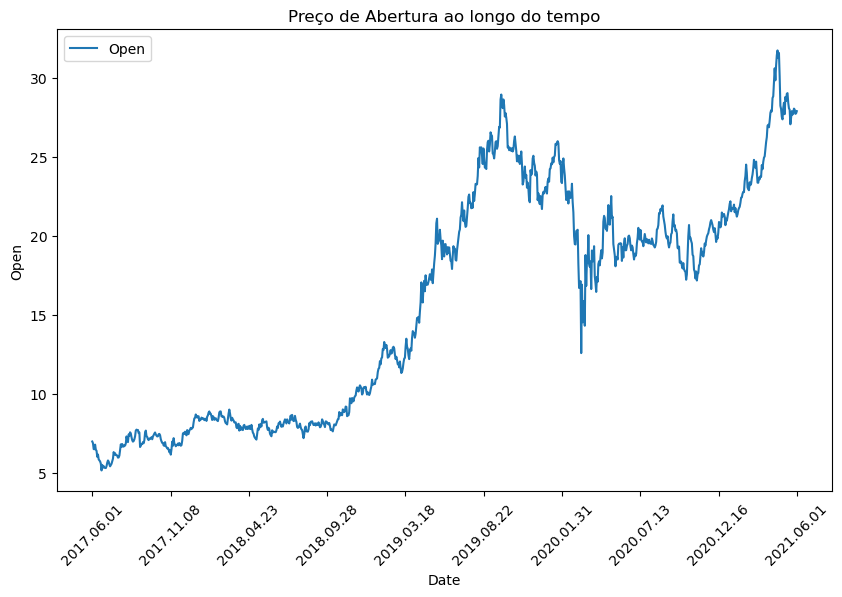

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['open'], label='Open')
plt.xlabel('Date')
plt.ylabel('Open')
plt.title('Preço de Abertura ao longo do tempo')
plt.legend()

# Reduzir o número de pontos no eixo x
num_ticks = 10  # Número de ticks no eixo x
plt.xticks(np.linspace(0, len(df['date']) - 1, num_ticks), rotation=45)

plt.show()

In [17]:
fundos = ['PETR4']
#resultados = []
for name in fundos:
    df = create_df(name)
    for normalization in ["minmax", "standard", "power", ""]:
        a,b,c,d,e,f = exp041(df, normalizer=normalization)
        #resultados.append({"Fundo":name, "Normalização":normalization, "Erro Max":a, "Erro Min":b})
        result_prediction = pd.DataFrame()
        result_prediction['date'] = getPeriod(df, TEST_BEGIN, TEST_END)['date']
        result_prediction['high_pred'] = c[:,0]
        result_prediction['low_pred'] = c[:,1]
        result_prediction['uncertainty_high'] = e[:,0]
        result_prediction['uncertainty_low'] = e[:,1]
        result_prediction['uncertainty_mean'] = (result_prediction['uncertainty_high'] + result_prediction['uncertainty_low']) / 2
        result_prediction['uncertainty_valid_mean'] = (f[:,0] + f[:,1]) / 2
        result_prediction['high'] = d[:,0] if normalization != "" else d['high']
        result_prediction['low'] = d[:,1] if normalization != "" else d['low']
        #result_prediction.to_pickle(f'../Data/{name}_Pred_with_confidence_and_valid_{normalization}.pkl')
        result_prediction.tail(10)

> c:\users\joaofelipemoraisvasc\appdata\local\temp\ipykernel_32740\2492289706.py(71)exp041()

array([[0.01530395, 0.01430992],
       [0.01884751, 0.01428972],
       [0.01555159, 0.0155965 ],
       [0.02195662, 0.02424757],
       [0.02039178, 0.02206941],
       [0.01760723, 0.01789592],
       [0.01665003, 0.01840576],
       [0.01657312, 0.01188178],
       [0.03090347, 0.03219063],
       [0.02357367, 0.02370088],
       [0.04367394, 0.04498321],
       [0.02843237, 0.02850105],
       [0.02418134, 0.03496905],
       [0.01754062, 0.02253479],
       [0.01567128, 0.02034579],
       [0.02434553, 0.02238628],
       [0.02731397, 0.01578507],
       [0.02472895, 0.01352389],
       [0.01997279, 0.01961257],
       [0.01612273, 0.01113826],
       [0.02244325, 0.01364775],
       [0.01793084, 0.01756959],
       [0.02575787, 0.01627281],
       [0.01653921, 0.01345689],
       [0.02366387, 0.01539069],
       [0.02200795, 0.01643672],
       [0.01905269, 0.02279237],
       [0.01848

In [9]:
# Converte a lista em um DataFrame
df_resultados = pd.DataFrame(resultados)

# Exibe o DataFrame
df_resultados.head(10)

,Fundo,Normalização,Erro Max,Erro Min
0,PETR4,minmax,"(1.6726904462818473, 1.9238844612955504)","(1.1824699917244497, 1.024169403932147)"
1,PETR4,standard,"(36.590645332576436, 79.30015623570763)","(17.136351802625096, 27.92080406035279)"
2,PETR4,power,"(48.08356690079402, 92.48692666034579)","(42.89074187508518, 77.38554485031747)"
3,PETR4,,"(0.8756323999920286, 1.0117735249066002)","(0.6664993684354711, 0.5464955439425301)"
4,JBSS3,minmax,"(3.7500464065922627, 3.515261786227369)","(4.213215256587764, 3.389909592267657)"
5,JBSS3,standard,"(6.8242627817200034, 6.191465007274104)","(7.490930591700725, 5.757447968264802)"
6,JBSS3,power,"(7.270801885224835, 6.350233195178166)","(7.9229012758205295, 5.924564061914279)"
7,JBSS3,,"(2.9861227841257643, 2.7110791455746823)","(3.3238848964776926, 2.6388664344536616)"
8,ABEV3,minmax,"(2.5724943776257967, 2.7280385119184825)","(2.1288037618848286, 1.3961757134967685)"
9,ABEV3,standard,"(165.3948224792481, 899.6214298556724)","(38.864039810130166, 76.20265326004207)"


In [13]:
df_resultados.loc[df_resultados['Fundo'] == 'BBDC4']

,Fundo,Normalização,Erro Max,Erro Min
12,BBDC4,minmax,"(1.8468747335769242, 1.4086268095516823)","(1.4746483870118727, 1.1402292866592456)"
13,BBDC4,standard,"(33.364773176040174, 82.13121758674919)","(14.953311373814213, 16.35424455986814)"
14,BBDC4,power,"(24.811794800264437, 46.118067824220944)","(13.190175800414334, 13.58903259994692)"
15,BBDC4,,"(0.6336564427264996, 0.5124348201700734)","(0.6508934713437111, 0.48695987076806163)"


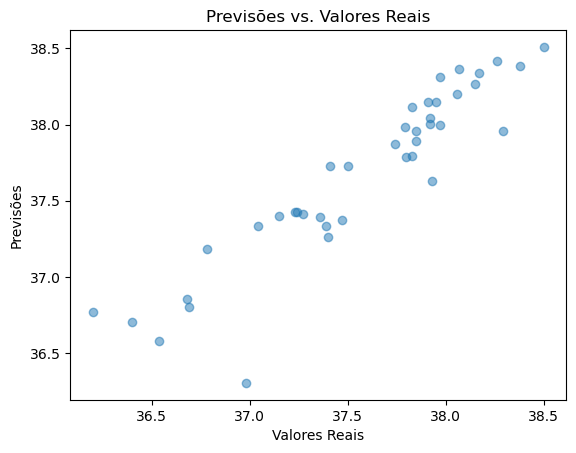

In [11]:
import matplotlib.pyplot as plt
plt.scatter(result_prediction['high'], result_prediction["high_pred"], alpha=0.5)
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title("Previsões vs. Valores Reais")
plt.show()


In [176]:
result_prediction.tail(10)

,date,high_pred,low_pred,uncertainty_high,uncertainty_low,uncertainty_mean,high,low
978,2021.05.19,37.401800,36.586000,0.300421,0.244292,0.272357,37.47,36.81
979,2021.05.20,37.434900,36.765800,0.225411,0.249618,0.237515,37.24,36.85
980,2021.05.21,37.421467,36.792200,0.189531,0.195824,0.192677,37.27,36.87
981,2021.05.24,37.653533,36.996333,0.257401,0.204080,0.230741,37.93,37.28
982,2021.05.25,38.173867,37.403867,0.261730,0.267548,0.264639,37.95,37.47
983,2021.05.26,38.086767,37.359200,0.185646,0.220377,0.203012,37.92,37.37
984,2021.05.27,37.775300,37.034767,0.220501,0.261028,0.240765,37.83,37.33
985,2021.05.28,37.705200,36.982333,0.222451,0.241862,0.232156,37.50,36.58
986,2021.05.31,37.342000,36.612933,0.158600,0.279448,0.219024,37.04,36.60
987,2021.06.01,37.351100,36.603333,0.182314,0.241235,0.211774,37.39,36.78


In [177]:
result_prediction['high_pred'].describe()

count    40.000000
mean     37.679176
std       0.580224
min      36.307833
25%      37.357525
50%      37.780033
75%      38.103717
max      38.524833
Name: high_pred, dtype: float64

## Análise incerteza PETR4

### Plots

Number of samples with uncertainty under 0.22460224927925132: 0
Number of samples with uncertainty under 0.25574859182864773: 2
Number of samples with uncertainty under 0.28689493437804414: 3
Number of samples with uncertainty under 0.31804127692744055: 4
Number of samples with uncertainty under 0.34918761947683696: 12
Number of samples with uncertainty under 0.3803339620262334: 17
Number of samples with uncertainty under 0.41148030457562973: 19
Number of samples with uncertainty under 0.44262664712502614: 23
Number of samples with uncertainty under 0.47377298967442255: 29
Number of samples with uncertainty under 0.504919332223819: 31
Number of samples with uncertainty under 0.5360656747732153: 32
Number of samples with uncertainty under 0.5672120173226118: 33
Number of samples with uncertainty under 0.5983583598720081: 35
Number of samples with uncertainty under 0.6295047024214045: 35
Number of samples with uncertainty under 0.660651044970801: 35
Number of samples with uncertainty und

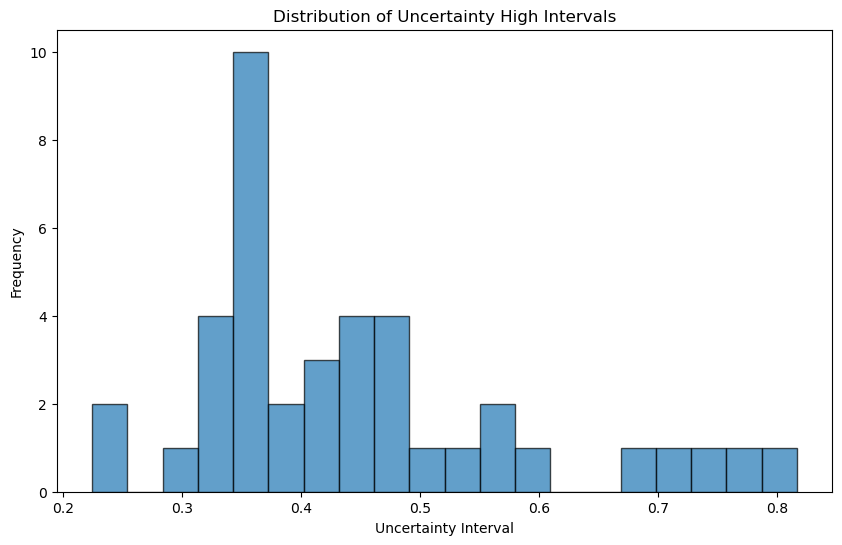

In [12]:
# Calculate the percentage of samples with uncenrtainty under certain thresholds
min_uncertainty = result_prediction["uncertainty_valid_mean"].min()
max_uncertainty = result_prediction["uncertainty_valid_mean"].max()

# Definindo um passo dinâmico (5% da diferença total)
steps = np.linspace(min_uncertainty, max_uncertainty, num=20)
steps = np.append(steps, 0)
counts = [(result_prediction['uncertainty_valid_mean'] < threshold).sum() for threshold in steps]

# Display the counts
for threshold, count in zip(steps, counts):
    print(f'Number of samples with uncertainty under {threshold}: {count}')

# Plot the distribution of the confidence column
plt.figure(figsize=(10, 6))
plt.hist(result_prediction['uncertainty_valid_mean'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Uncertainty High Intervals')
plt.xlabel('Uncertainty Interval')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Filter the samples with uncertainty under 0.5
filtered_df = d[(d['uncertainty_high'] < 0.5) & (d['uncertainty_low'] < 0.5)]

# Calculate the proximity for high and low predictions
filtered_df['high_proximity'] = abs(filtered_df['high_pred'] - filtered_df['high'])
filtered_df['low_proximity'] = abs(filtered_df['low_pred'] - filtered_df['low'])

# Display the filtered dataframe with proximity columns
filtered_df[['date', 'high', 'high_pred', 'high_proximity', 'low', 'low_pred', 'low_proximity', 'uncertainty_high', 'uncertainty_low']]

,date,high,high_pred,high_proximity,low,low_pred,low_proximity,uncertainty_high,uncertainty_low
1299,2021.04.06,23.58,23.658367,0.078367,23.13,23.051900,0.078100,0.306014,0.185476
1300,2021.04.07,23.55,23.587967,0.037967,23.15,23.045100,0.104900,0.262735,0.213800
1301,2021.04.08,23.26,23.578233,0.318233,22.61,23.010100,0.400100,0.238466,0.196970
1302,2021.04.09,23.01,23.179900,0.169900,22.61,22.526967,0.083033,0.323983,0.325594
1303,2021.04.12,23.58,23.701800,0.121800,23.01,22.942000,0.068000,0.424612,0.194096
1304,2021.04.13,23.33,23.598000,0.268000,22.92,22.950067,0.030067,0.297761,0.189986
1305,2021.04.14,23.78,23.718833,0.061167,23.20,23.029733,0.170267,0.345249,0.204335
1306,2021.04.15,23.83,23.856933,0.026933,23.02,23.317967,0.297967,0.251262,0.315487
1307,2021.04.16,23.24,23.556633,0.316633,22.81,22.944200,0.134200,0.262153,0.225210
1308,2021.04.19,24.89,23.415367,1.474633,22.77,22.696767,0.073233,0.367120,0.259598


Number of samples with uncertainty under 0.21: 5
Number of samples with uncertainty under 0.26: 22
Number of samples with uncertainty under 0.321: 34
Number of samples with uncertainty under 0.4: 39
Number of samples with uncertainty under 0.5: 40
Number of samples with uncertainty under 0.6: 40
Number of samples with uncertainty under 0.7: 40
Number of samples with uncertainty under 0.8: 40
Number of samples with uncertainty under 0.9: 40


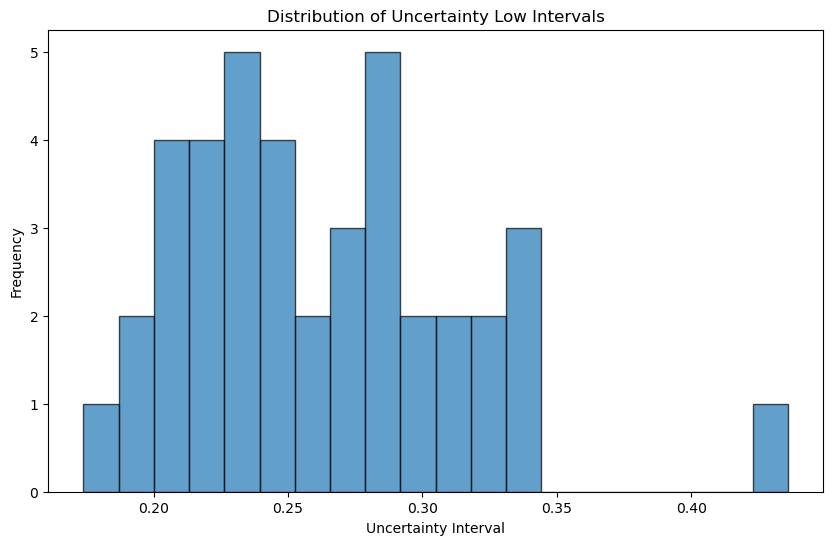

In [26]:
# Calculate the percentage of samples with uncenrtainty under certain thresholds
thresholds = [0.21,0.26,0.321,0.4,0.5, 0.6, 0.7, 0.8, 0.9]
counts = [(d['uncertainty_mean'] < threshold).sum() for threshold in thresholds]

# Display the counts
for threshold, count in zip(thresholds, counts):
    print(f'Number of samples with uncertainty under {threshold}: {count}')

# Plot the distribution of the confidence column
plt.figure(figsize=(10, 6))
plt.hist(d['uncertainty_mean'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Uncertainty Low Intervals')
plt.xlabel('Uncertainty Interval')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import yfinance as yf

# Define o ticker da PETR4 (B3 usa .SA no Yahoo Finance)
ticker = "PETR4.SA"

# Define o período de tempo desejado
start_date = "2025-01-01"
end_date = "2025-12-31"

# Baixa os dados históricos
df = yf.download(ticker, start=start_date, end=end_date)

# Exibe as primeiras linhas do dataframe
print(df.head())
